In [2]:
import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.pyplot import figure
import fastf1 as ff1
from fastf1 import plotting
import time
from datetime import datetime, date, time, timedelta
from timple.timedelta import strftimedelta
from fastf1.core import Laps
import matplotlib.image as image
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [3]:
#enabling the cache for the data
ff1.Cache.enable_cache('f1cache')

#importing the data
race = ff1.get_session(2022, 'Austria', 'race')
laps= race.load_laps(with_telemetry=True)
results= race.results
session=race

Use `Session.load` instead.
core           INFO 	Loading data for Austrian Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']


In [4]:
#looking at the laps data columns and data inside
laps.head(2)

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:27.742000,16,NaT,1,1,0 days 00:22:46.904000,NaT,NaT,0 days 00:00:31.635000,0 days 00:00:21.223000,...,False,MEDIUM,1.0,True,0 days 01:02:13.798000,Ferrari,LEC,1,False,2022-07-10 13:03:13.807
1,0 days 01:04:38.351000,16,0 days 00:01:10.609000,2,1,NaT,NaT,0 days 00:00:17.892000,0 days 00:00:31.390000,0 days 00:00:21.327000,...,False,MEDIUM,2.0,True,0 days 01:03:27.742000,Ferrari,LEC,1,True,2022-07-10 13:04:27.751


In [5]:
#picking the laps for each driver

ver = laps.pick_driver('VER')
ham = laps.pick_driver('HAM')
gas = laps.pick_driver('GAS')
lec = laps.pick_driver('LEC')
alo = laps.pick_driver('ALO')
sai = laps.pick_driver('SAI')
oco = laps.pick_driver('OCO')
nor = laps.pick_driver('NOR')
vet = laps.pick_driver('VET')
zho = laps.pick_driver('ZHO')
rus = laps.pick_driver('RUS')
tsu = laps.pick_driver('TSU')
lat = laps.pick_driver('LAT')
mag = laps.pick_driver('MAG')
msc = laps.pick_driver('MSC')
ric = laps.pick_driver('RIC')
str = laps.pick_driver('STR')
bot = laps.pick_driver('BOT')
per = laps.pick_driver('PER')
alb = laps.pick_driver('ALB')

## Cleaning Up Data by removing laps with no lap times and removing lap times 3 std above the mean of the race, also cleaning up the individual sector times by doing the same thing

In [6]:
#for loop that cleans the data because it has to run 4-5 times to normalize the data
for lap in range(5):
    #turn LapTime into seconds from DD:HH:MM:SS
    laps['LapTime_seconds'] = laps['LapTime'].dt.total_seconds()

    #drop all rows with NaN in LapTime_seconds
    laps = laps.dropna(subset=['LapTime_seconds'])

    laptimemean=laps['LapTime_seconds'].mean()
    laptimestd=laps['LapTime_seconds'].std()

    #drop all rows in laps with LapTime_seconds 3 std greater than the mean lap time
    laps = laps[laps['LapTime_seconds'] < (laptimemean + 3*laptimestd)]
    

    #doing the same for Sector1Time, Sector2Time, Sector3Time
    laps['Sector1Time_seconds'] = laps['Sector1Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector1Time_seconds'])
    laps['Sector2Time_seconds'] = laps['Sector2Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector2Time_seconds'])
    laps['Sector3Time_seconds'] = laps['Sector3Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector3Time_seconds'])
    
    #finding the mean and std of the Sector times
    sector1mean=laps['Sector1Time_seconds'].mean()
    sector1std=laps['Sector1Time_seconds'].std()
    sector2mean=laps['Sector2Time_seconds'].mean()
    sector2std=laps['Sector2Time_seconds'].std()
    sector3mean=laps['Sector3Time_seconds'].mean()
    sector3std=laps['Sector3Time_seconds'].std()

    #drop all rows in laps with Sector1Time 3 std greater than the mean sector time
    laps = laps[laps['Sector1Time_seconds'] < (sector1mean + 3*sector1std)]
    #drop all rows in laps with Sector2Time 3 std greater than the mean sector time
    laps = laps[laps['Sector2Time_seconds'] < (sector2mean + 3*sector2std)]
    #drop all rows in laps with Sector3Time 3 std greater than the mean sector time
    laps = laps[laps['Sector3Time_seconds'] < (sector3mean + 3*sector3std)]

## Creating a stat deltaS1+,deltaS2+ and deltaS3+ which is sectormean-Sector_Time_seconds

In [7]:
laps['deltaS1+']=((sector1mean-laps['Sector1Time_seconds'])*100).round()#finding the delta between the mean and the sector time
laps['deltaS2+']=((sector2mean-laps['Sector2Time_seconds'])*100).round()
laps['deltaS3+']=((sector3mean-laps['Sector3Time_seconds'])*100).round()


#drop the float point from the deltaS1+ and deltaS2+ and deltaS3+
laps['deltaS1+']=laps['deltaS1+'].astype(int)
laps['deltaS2+']=laps['deltaS2+'].astype(int)
laps['deltaS3+']=laps['deltaS3+'].astype(int)

#make a new data frame called secPlus that has the drivers and the deltaS1+, deltaS2+, deltaS3+
secPlus=laps[['Driver','deltaS1+','deltaS2+','deltaS3+']]

#creating a dataframe that has the drivers and their average deltaS1+, deltaS2+, deltaS3+ scores
secPlusScores=secPlus.groupby('Driver').mean().reset_index()

#round deltaS1+,deltaS2+,deltaS3+ to the nearest integer and then remove the float point
secPlusScores['deltaS1+']=secPlusScores['deltaS1+'].round(0).astype(int)
secPlusScores['deltaS2+']=secPlusScores['deltaS2+'].round(0).astype(int)
secPlusScores['deltaS3+']=secPlusScores['deltaS3+'].round(0).astype(int)

secPlusScores.head(2)

,Driver,deltaS1+,deltaS2+,deltaS3+
0,ALB,6,-24,-13
1,ALO,7,-7,-9


## Seperating the data and visualizing it in a table

In [8]:
#seperate the data into the drivers and the deltaS1+, deltaS2+, deltaS3+
sector1scores=secPlusScores[['Driver','deltaS1+']].sort_values(by='deltaS1+',ascending=False)
sector2scores=secPlusScores[['Driver','deltaS2+']].sort_values(by='deltaS2+',ascending=False)
sector3scores=secPlusScores[['Driver','deltaS3+']].sort_values(by='deltaS3+',ascending=False)

#show sector1scores,sector2scores,sector3scores side by side
from IPython.display import display_html 

df1_styler = sector1scores.style.set_table_attributes("style='display:inline',").set_caption('Delta Sector1+')
df2_styler = sector2scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector2+')
df3_styler = sector3scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector3+')
#hide the index
df1_styler.hide_index()
df2_styler.hide_index()
df3_styler.hide_index()
display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

Driver,deltaS1+
VER,11
LEC,11
HAM,7
ALO,7
ALB,6
BOT,6
MSC,4
ZHO,3
SAI,1
RUS,0


## Visualizing Delta Sector+ to put into perspective for others

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


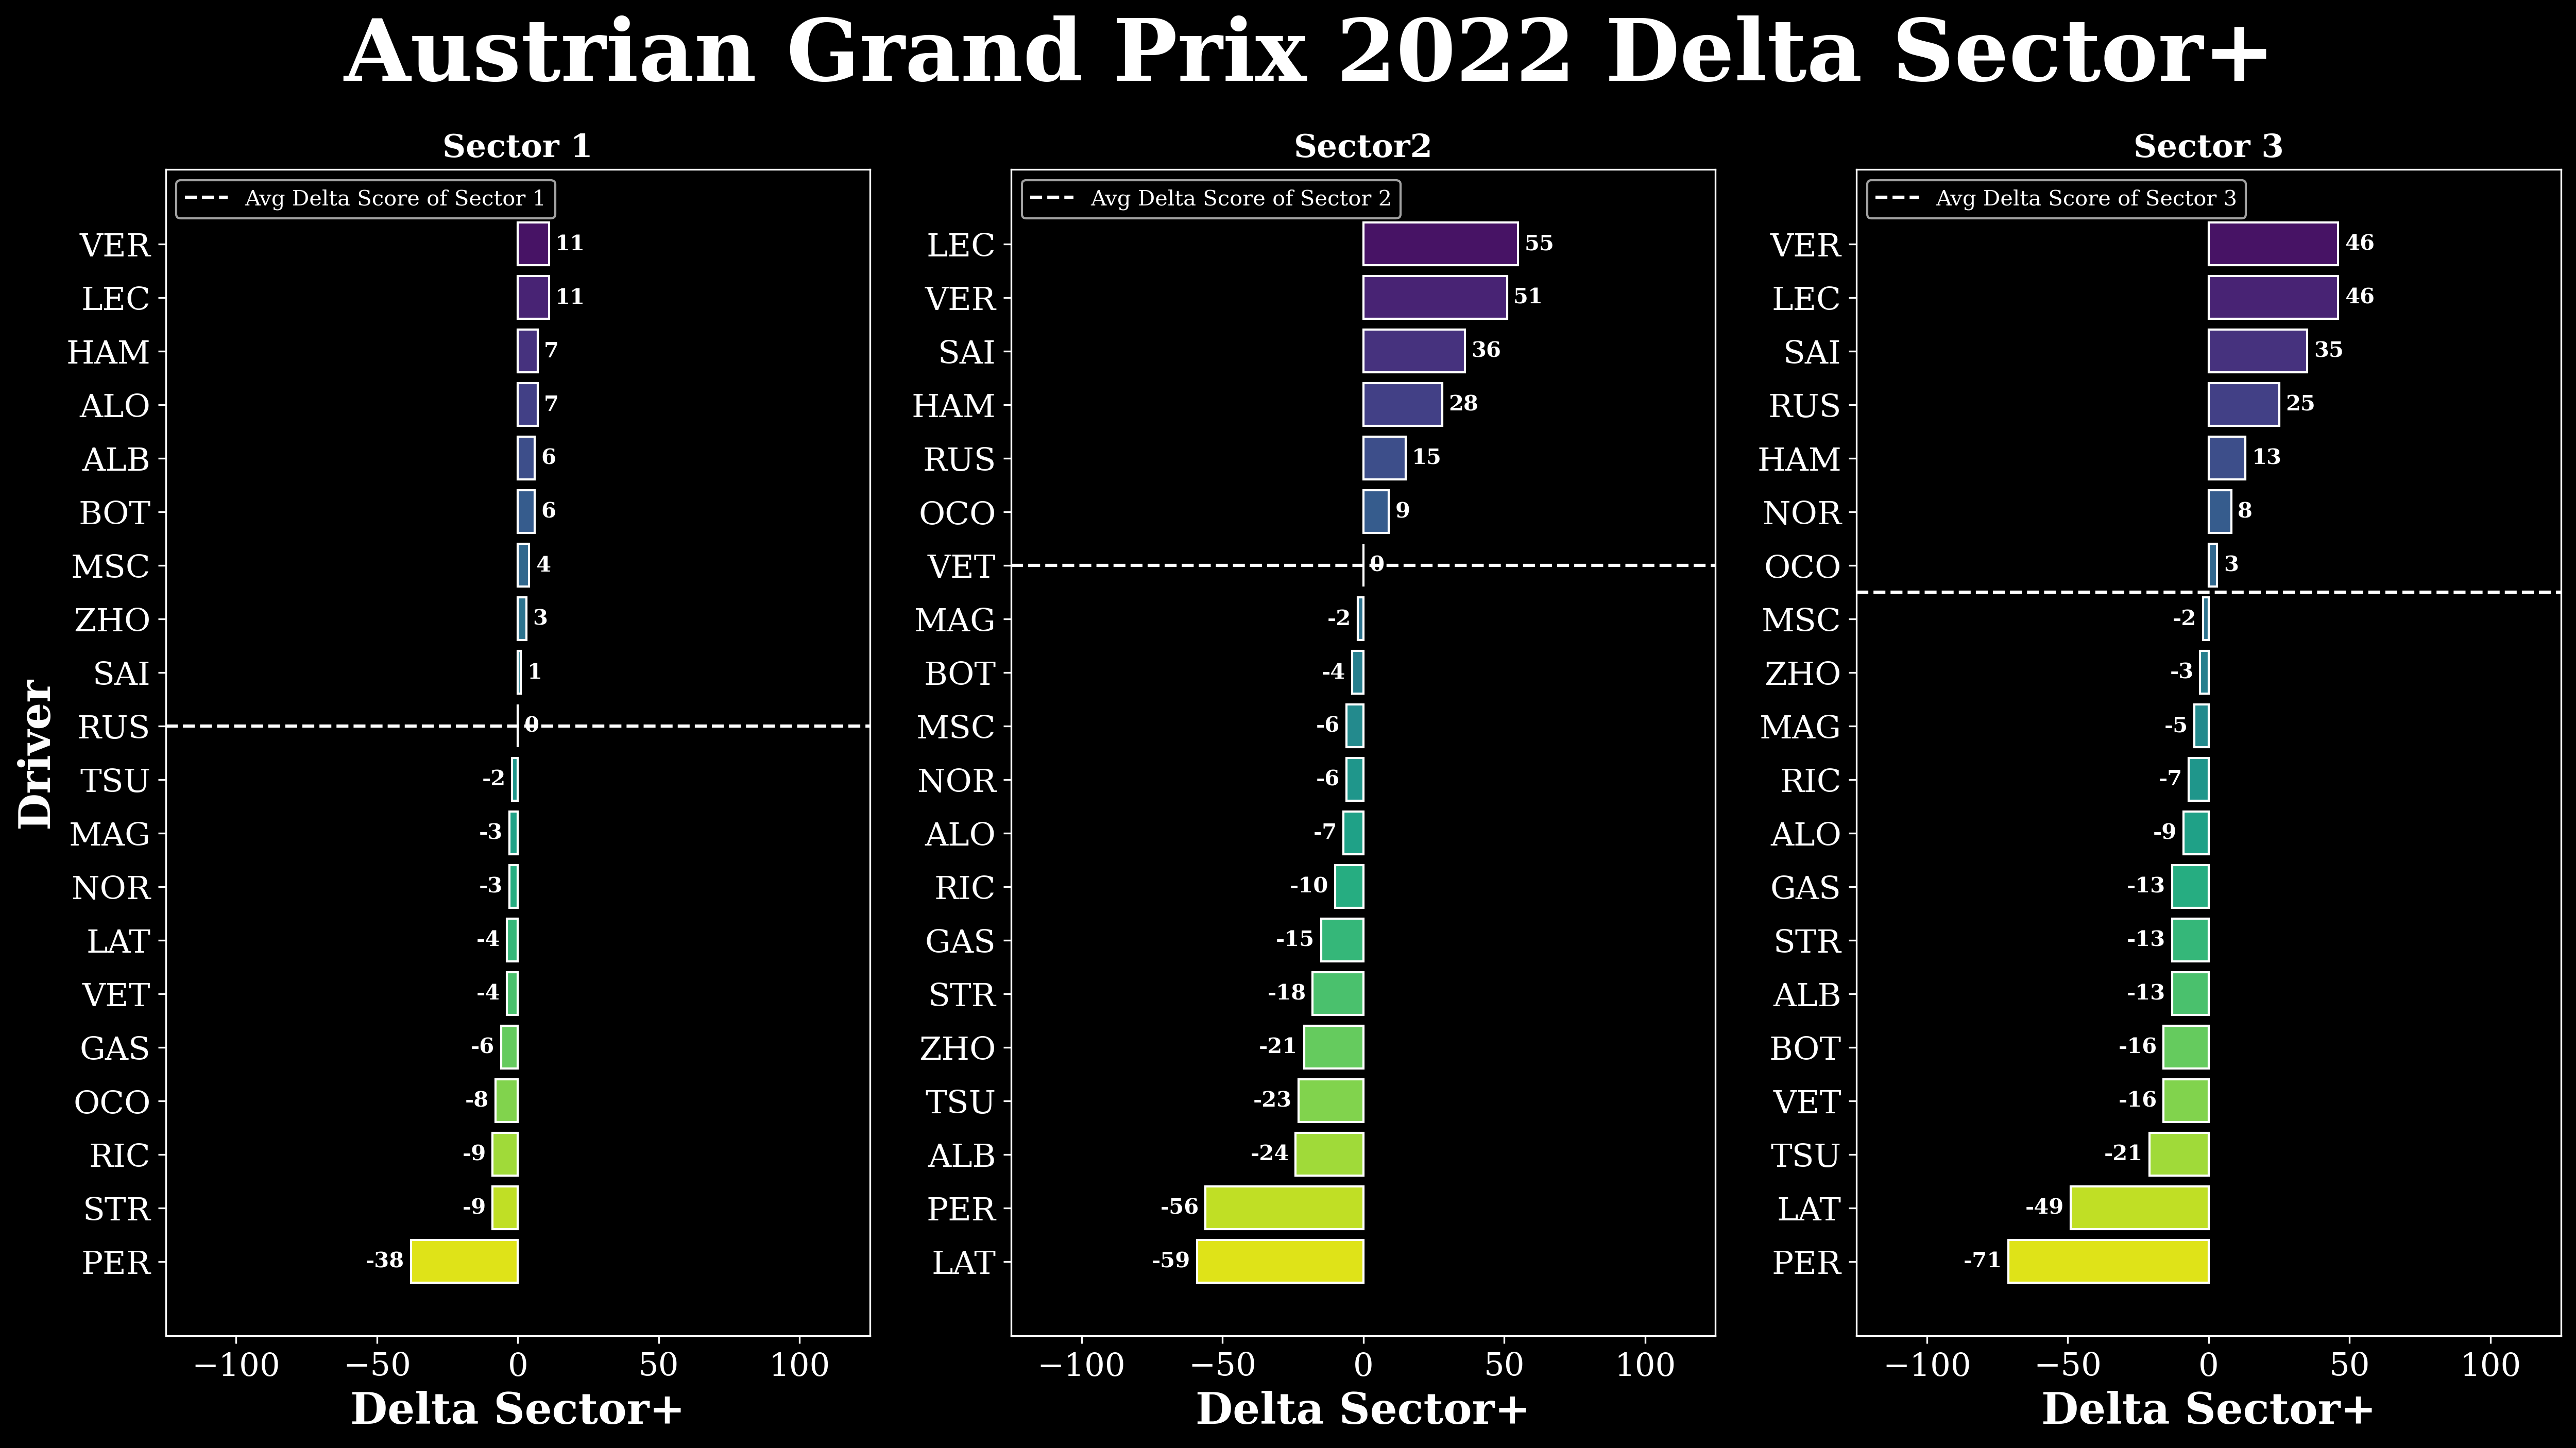

In [9]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.suptitle(f'{race.weekend.name} {race.weekend.year} Delta Sector+ ', fontsize=40, fontweight='bold')

#create a color palette for seaborn that goes from yellow to green to purple
colors=['#FFF817','#EDDC26','#37AB16','#69359C']

#bar plot for sector1
pd1=axs[0].barh(sector1scores['Driver'],sector1scores['deltaS1+'],edgecolor='white',color=sns.color_palette("viridis", len(sector1scores['Driver'])))
axs[0].set_title('Sector 1', fontsize=15, fontweight='bold')
axs[0].invert_yaxis()
axs[0].bar_label(pd1,padding=3,fontweight='bold')

#find where driver deltaS1+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector1scores['deltaS1+']):
    if v == 0:
        axs[0].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
    elif v < 0:
        axs[0].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
axs[0].tick_params(labelsize=15)
axs[0].set_xlim(-125,125)
axs[0].set_xlabel('Delta Sector+', fontsize=20, fontweight='bold')
axs[0].legend(loc='upper left', fontsize=10)
axs[0].set_ylabel('Driver', fontsize=20, fontweight='bold')

#bar plot for sector2
pd2=axs[1].barh(sector2scores['Driver'],sector2scores['deltaS2+'],edgecolor='white',color=sns.color_palette("viridis", len(sector2scores['Driver'])))
axs[1].set_title('Sector2', fontsize=15, fontweight='bold')
axs[1].invert_yaxis()
axs[1].bar_label(pd2,padding=3,fontweight='bold')

#find where driver deltaS2+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector2scores['deltaS2+']):
    if v == 0:
        axs[1].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
    elif v < 0:
        axs[1].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
axs[1].tick_params(labelsize=15)
axs[1].set_xlim(-125,125)
axs[1].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[1].legend(loc='upper left', fontsize=10)


#bar plot for sector3
pd3=axs[2].barh(sector3scores['Driver'],sector3scores['deltaS3+'],edgecolor='white',color=sns.color_palette("viridis", len(sector3scores['Driver'])))
axs[2].set_title('Sector 3', fontsize=15, fontweight='bold')
axs[2].invert_yaxis()
axs[2].bar_label(pd3,padding=3,fontweight='bold')

#find where driver deltaS3+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector3scores['deltaS3+']):
    if v == 0:
        axs[2].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
    elif v < 0:
        axs[2].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
axs[2].tick_params(labelsize=15)

#set the x axis ticks to -150 to 150
axs[2].set_xlim(-125,125)
axs[2].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[2].legend(loc='upper left', fontsize=10)

#plt.savefig(f'f1plots\{race.weekend.name} {race.weekend.year}DeltaSectorPlusBarChart.png')
plt.show()